In [ ]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import random
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
import math
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report, roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
!pip3 install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap
from google.colab import drive 

Instructions for updating:
non-resource variables are not supported in the long term
     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 371 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509258 sha256=8c982477f1a443395197102881d4c40e212db62a45996d644ec6dd09dcb3c339
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 로딩
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_iter.csv')
df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_5.csv')
# df = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/time_series_knn_20.csv')
#del df["Unnamed: 0.1"]
df = df[['hadm_id', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'spo2', 'crystalloid_bolus', 'rbc', 'urine', 'event']]
df

,hadm_id,sbp,dbp,resp,hr,temp_c,spo2,crystalloid_bolus,rbc,urine,event
0,199780,84.0,47.0,16.7,58.00,36.822240,83.200000,0.0,0.0,0.0,1.0
1,199780,90.0,52.0,16.0,58.00,36.777802,82.133333,0.0,0.0,0.0,1.0
2,199780,93.0,39.0,20.0,63.00,36.900020,86.500000,0.0,0.0,500.0,1.0
3,199780,103.0,40.0,20.0,56.00,36.333360,83.200000,0.0,0.0,0.0,1.0
4,199780,106.0,55.0,14.4,61.00,36.733360,88.800000,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
33067,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33068,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33069,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0
33070,100001,111.4,59.8,26.2,77.65,36.677750,89.200000,0.0,0.0,0.0,0.0


In [ ]:
st = pd.read_csv('/content/drive/Shareddrives/생체EMR 5팀/Data/static_df.csv')
df = st.iloc[:,:3].merge(df)

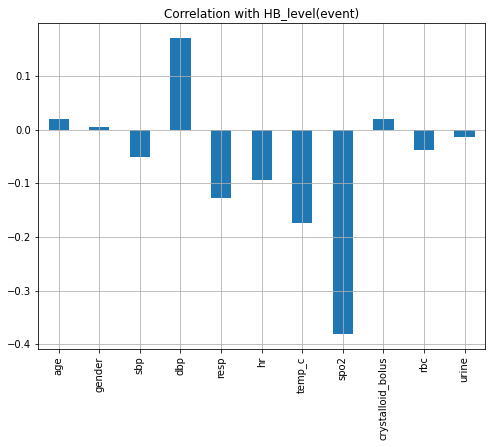

In [ ]:
# event와 다른 feature 간의 correlation 

df.drop(['hadm_id', 'event'], axis=1).corrwith(df.event).plot(kind='bar', grid=True, figsize=(8, 6), title="Correlation with HB_level(event)")

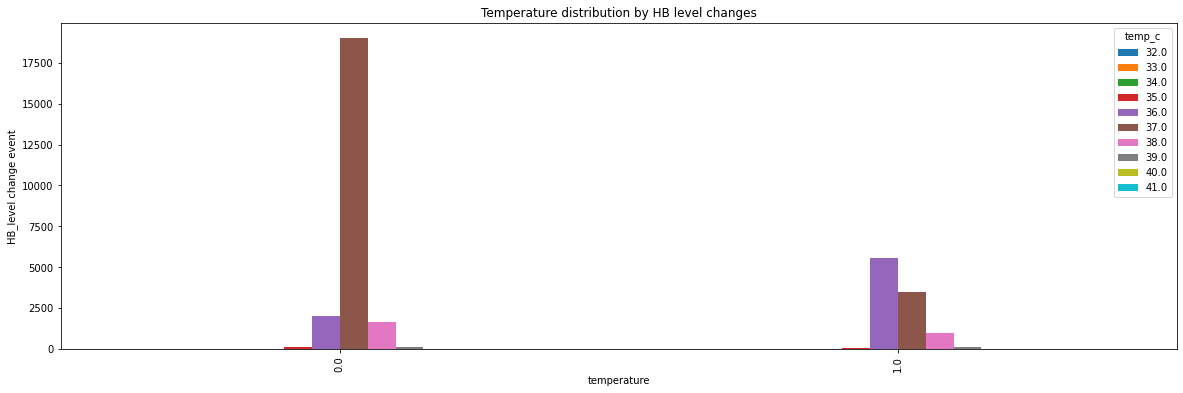

In [ ]:
pd.crosstab(df.event,df.temp_c.round()).plot(kind="bar",figsize=(20,6))
plt.title('Temperature distribution by HB level changes')
plt.xlabel('temperature')
plt.ylabel('HB_level change event')
plt.show()

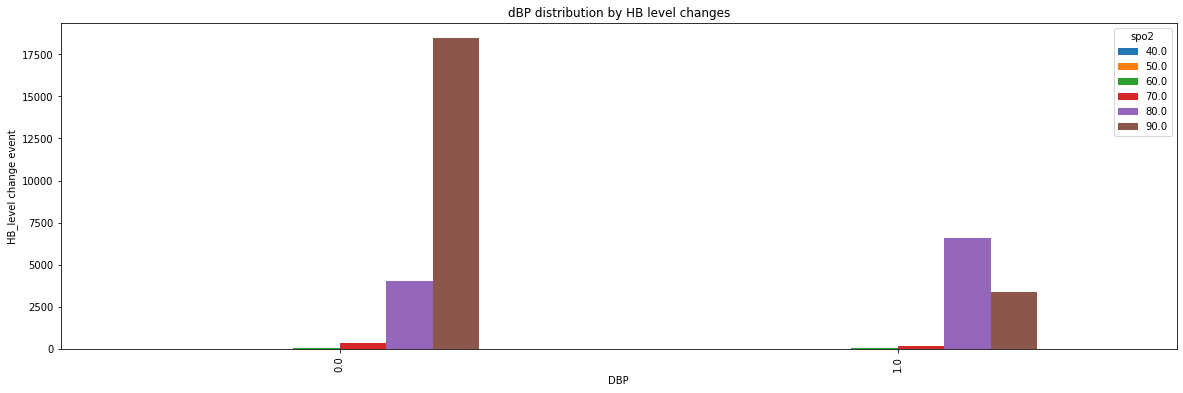

In [ ]:
pd.crosstab(df.event,df.spo2.round(-1)).plot(kind="bar",figsize=(20,6))
plt.title('dBP distribution by HB level changes')
plt.xlabel('DBP')
plt.ylabel('HB_level change event')
plt.show()

In [ ]:
# hadm_id 중복없이 리스트로 뽑고, df의 hadm_id에 해당하는 column의 데이터(프레임)를 x에 numpy array로 저장 
# hadm_id가 중복되면 (case 2개 이상), 한 hadm_id에 numpy array가 24 단위로 증가된 것만 남고, 나머지는 제거됨   

# hadm_id =list(set(df['hadm_id'].tolist()))
# column_name = ['sbp', 'dbp', 'resp', 'hr', 'temp_c', 'spo2', 'crystalloid_bolus', 'rbc', 'urine', 'event']
# x = [df[df['hadm_id']==i][column_name].to_numpy() for i in hadm_id]


In [ ]:
hadm_id =list(set(df['hadm_id'].tolist()))
column_name = ['age', 'gender', 'sbp', 'dbp', 'resp', 'hr', 'temp_c', 'spo2', 'crystalloid_bolus', 'rbc', 'urine', 'event']
x = [df[df['hadm_id']==i][column_name].to_numpy() for i in hadm_id]

In [ ]:
# 입력 데이터 만들기 
# x를 받아서 array가 48인 것은 event값에 따라 나누고, 24인 것과 최종 final_x, final_y로 지정

def data_split(np_array_list):
  final_x, final_y = [], []
  for np_array in np_array_list:
    if len(np_array) == 48:
      final_x.append(np_array[np.where(np_array[:, -1]==0)][:, :-1])
      final_y.append(0)
      final_x.append(np_array[np.where(np_array[:, -1]==1)][:, :-1])
      final_y.append(1)
    else:
      label = np_array[0, -1]
      final_x.append(np_array[:, :-1])
      final_y.append(label)

  return np.array(final_x), np.array(final_y)

In [ ]:
final_x, final_y = data_split(x)
print("x shape:", final_x.shape, "y shape:", final_y.shape)

x shape: (1378, 24, 11) y shape: (1378,)


In [ ]:
# train/test set 나누기 (7:3)  (colab에서 fit -> validation_data에 오류있어 사용 어려움)

x_train, x_test, y_train, y_test = train_test_split(final_x, final_y, random_state=100, test_size=0.3, shuffle=True) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(964, 24, 11)
(414, 24, 11)
(964,)
(414,)


In [ ]:
# 데이터 불균형 정도
neg, pos = np.bincount(df['event'])
total = neg + pos
print('Total: {}\n  Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total: 33072
  Positive: 10200 (30.84% of total)

Weight for class 0: 0.72
Weight for class 1: 1.62


In [ ]:
# Token Embedding 및 Poisitional Encoding Block 구현
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.token_emb = layers.Dense(embed_dim, activation='relu')

    def get_angles(self):
      pos = np.arange(self.maxlen)[:, np.newaxis]
      i = np.arange(self.embed_dim)[np.newaxis, :]
      angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.embed_dim))
      return pos * angle_rates

    def pos_enc(self):
      angle_rads = self.get_angles()
      
      # 짝수 인덱스에 sin 적용; 2i
      angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
      # 홀수 인덱스에 cos 적용; 2i+1
      angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      pos_encoding = angle_rads[np.newaxis, ...]

      return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        positions = self.pos_enc()
        x = self.token_emb(x) * tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        return x + positions

In [ ]:
# Transformer Block 구현
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# 분류 모델

HB_model = keras.Sequential([
    TokenAndPositionEmbedding(maxlen=24, embed_dim=32),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    TransformerBlock(embed_dim=32, num_heads=4, ff_dim=128, rate=0.05),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
## 모델 학습

from keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min')
HB_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
num_epochs = 200
history = HB_model.fit(x_train, y_train, epochs=num_epochs, class_weight = class_weight, batch_size = 15, validation_split=0.2, callbacks = [early_stopping], verbose=1)


Train on 771 samples, validate on 193 samples
Epoch 1/200
735/771 [===========================>..] - ETA: 0s - loss: 0.7145 - acc: 0.5524

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


771/771 [==============================] - 1s 2ms/sample - loss: 0.7111 - acc: 0.5655 - val_loss: 0.6804 - val_acc: 0.3834
Epoch 2/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.6790 - acc: 0.5344 - val_loss: 0.7428 - val_acc: 0.3005
Epoch 3/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.6114 - acc: 0.6459 - val_loss: 0.6039 - val_acc: 0.7150
Epoch 4/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.5928 - acc: 0.6316 - val_loss: 0.6067 - val_acc: 0.7772
Epoch 5/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.4912 - acc: 0.7575 - val_loss: 0.4461 - val_acc: 0.7772
Epoch 6/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.4648 - acc: 0.7471 - val_loss: 0.4426 - val_acc: 0.8394
Epoch 7/200
771/771 [==============================] - 1s 1ms/sample - loss: 0.3954 - acc: 0.8016 - val_loss: 0.3683 - val_acc: 0.8135
Epoch 8/200
771/771 [==============================] - 1s 1ms/sampl

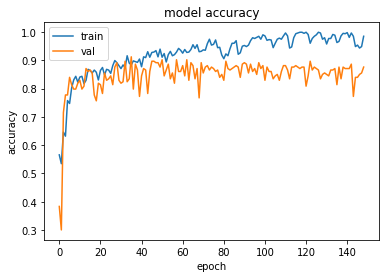

In [ ]:
# Model Accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

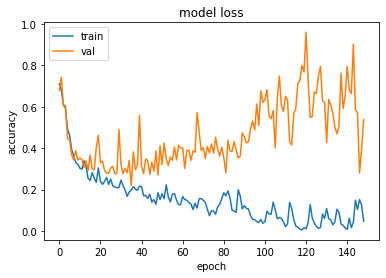

In [ ]:
# Model Loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# 모델 평가

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='skyblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


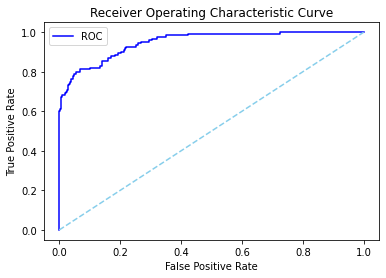

In [ ]:
y_pred = (HB_model.predict(x_test) > 0.5).astype("int32")
y_prob = HB_model.predict_on_batch(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [ ]:
#loss, accuracy = ls_model.evaluate(x_test, y_test, batch_size=1) 
#print('Loss: %.4f' % loss, 'Accuracy: % .4f' % accuracy )
print("{} Accuracy Score: {:.2f}%".format(2, accuracy_score(y_test, y_pred)*100))
print('AUC: %.4f' % roc_auc_score(y_test, HB_model.predict(x_test)))
print(classification_report(y_test, y_pred))

2 Accuracy Score: 87.68%
AUC: 0.9492
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91       291
         1.0       0.78      0.81      0.80       123

    accuracy                           0.88       414
   macro avg       0.85      0.86      0.85       414
weighted avg       0.88      0.88      0.88       414



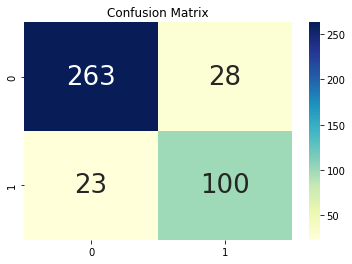

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='all')
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d", cbar=True, annot_kws={"size": 26})

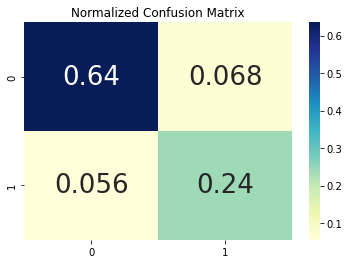

In [ ]:
plt.title("Normalized Confusion Matrix")
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", cbar=True, annot_kws={"size": 26})